In [1]:

import numpy as np
from casadi import *
import casadi as cs
import matplotlib.pyplot as plt
import seaborn as sns
from util import *
import itertools 
from time import perf_counter

In [2]:
!echo $PYTHONPATH

/home/randychen233/projects/ICON_lab/decentralized/:/home/randychen233/projects/ICON_lab/pocketknives/


In [3]:
from decentralized import util

In [4]:
%load_ext autoreload
%autoreload 2

## An example of using Casadi to optimize trajectory for a single quadrotor:

In [49]:
# x0 = np.random.rand(6*3,1)
x0 = np.array([0.1, 0.1, 1.0, 0.1, 0.1, 0.1])
xf = np.array([1.2, 1.2, 1.8, 0, 0, 0])
Q = np.diag([5,5,5,1,1,1])
R = np.eye(3)*0.01
Qf = np.eye(6)*1000
g = 9.8

u_ref = np.array([0,0,g])
N = 100

opti = Opti()

dt = 0.05

In [50]:
# models = [quad6D,quad6D,quad6D]

In [51]:
# ids = [i for i in range(n_agents)]

In [52]:
# quad6D(xf,Q,R,Qf,u_ref,N).cost()

In [53]:
# dynamics = MultiDynamicalModel([model(split_agents(xf.T,x_dims)[id_],Q,R,Qf,split_agents(u_ref.T,u_dims)[id_],N) for model,id_ in zip(models,ids)])

In [54]:
# problem = quadProblem()

In [55]:
X = opti.variable(6,N+1)
U = opti.variable(3,N)

In [56]:
# x_dims = [6,6,6,6]

In [57]:
g = 9.81

In [58]:
f = lambda x,u: vertcat(x[3],x[4],x[5],g*tan(u[0]),-g*tan(u[1]),u[2]-g) #dx/dt = f(x,u)

In [59]:
for k in range(N): #loop over control intervals
    # Runge-Kutta 4 integration
    k1 = f(X[:,k],         U[:,k])
    k2 = f(X[:,k]+dt/2*k1, U[:,k])
    k3 = f(X[:,k]+dt/2*k2, U[:,k])
    k4 = f(X[:,k]+dt*k3,   U[:,k])
    x_next = X[:,k] + dt/6*(k1+2*k2+2*k3+k4) 

    opti.subject_to(X[:,k+1]==x_next) # close the gaps


In [60]:
total_stage_cost = 0
for j in range(X.shape[1]-1):
    for i in range(X.shape[0]):
        total_stage_cost += (X[i,j]-xf[i])*Q[i, i]*(X[i,j]-xf[i])

for j in range(U.shape[1]-1):
    for i in range(U.shape[0]):
        total_stage_cost += (U[i,j]-u_ref[i])*R[i, i]*(U[i,j]-u_ref[i])

#Quadratic terminal cost:
total_terminal_cost = 0
# for j in range(X.shape[1]):
for i in range(X.shape[0]):
    total_terminal_cost += (X[i,-1]-xf[i])*Qf[i, i]*(X[i,-1]-xf[i])

In [61]:
objective = total_terminal_cost + total_stage_cost
# objective = total_stage_cost


In [62]:
opti.minimize(objective) 

In [63]:
opti.subject_to(X[2,:]<=3.0) # altitude p_z is limited
opti.subject_to(0.4<=X[2,:])

opti.subject_to(X[0,:]<=3) # p_x is limited
opti.subject_to(-3<=X[0,:])

opti.subject_to(X[1,:]<=3) # p_y is limited
opti.subject_to(-3<=X[1,:])

opti.subject_to(U[0,:]<=np.pi/6) # theta is limited
opti.subject_to(-np.pi/6<=U[0,:])

opti.subject_to(U[1,:]<=np.pi/6) # phi is limited
opti.subject_to(-np.pi/6<=U[1,:])

opti.subject_to(U[2,:]<=25) # tau is limited
opti.subject_to(0<=U[2,:]) #minimum force 

# opti.subject_to(X[0:3,-1] == xf[0:3])
#equality constraints:
opti.subject_to(X[:,0] == x0)
t0 = perf_counter()
opti.solver('ipopt');
sol = opti.solve()
tf = perf_counter()

print(f'total run time is {tf-t0} seconds')


This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     2106
Number of nonzeros in inequality constraint Jacobian.:     1206
Number of nonzeros in Lagrangian Hessian.............:      905

Total number of variables............................:      906
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      606
Total number of inequality constraints...............:     1206
        inequality constraints with only lower bounds:      603
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      603

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.2750796e+03 1.00e+00 2.19e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [64]:
X_trj = sol.value(X)
U_trj = sol.value(U)

In [65]:
U_trj.shape

(3, 100)

Text(0.5, 0.92, 'Trajectory from one-shot optimization')

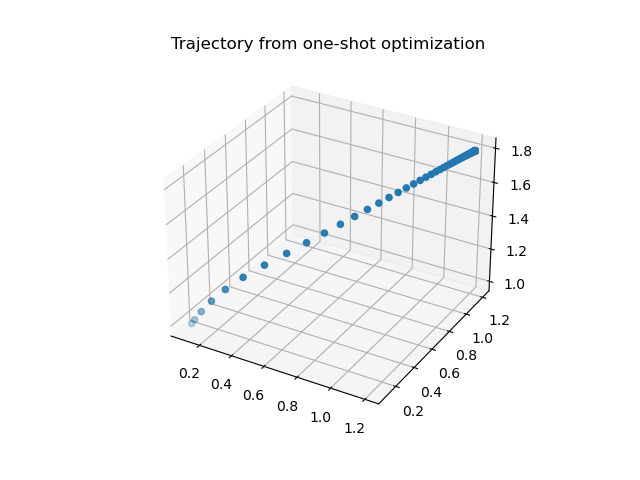

In [66]:
%matplotlib ipympl
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(X_trj[0,:],X_trj[1,:],X_trj[2,:])
ax.set_title('Trajectory from one-shot optimization')


In [67]:
pos_err = np.linalg.norm(X_trj[0:3,-1]-xf[0:3])
pos_err

5.2727072380359054e-06

## Running the above optimizaiton but in a receding-horizon fashion:
In this case, we relax the terminal state constraint and impose a terminal state cost into the objective function. The reason is that each optimization step is solved over a control horizon, and it's not possible that the drone reaches its goal after each control horizon (which keeps shifting forward)

In [ ]:
def objective(X,U,u_ref,xf,Q,R,Qf):
    total_stage_cost = 0
    for j in range(X.shape[1]-1):
        for i in range(X.shape[0]):
            total_stage_cost += (X[i,j]-xf[i])*Q[i, i]*(X[i,j]-xf[i])

    for j in range(U.shape[1]-1):
        for i in range(U.shape[0]):
            total_stage_cost += (U[i,j]-u_ref[i])*R[i, i]*(U[i,j]-u_ref[i])

    #Quadratic terminal cost:
    total_terminal_cost = 0

    for i in range(X.shape[0]):
        total_terminal_cost += (X[i,-1]-xf[i])*Qf[i, i]*(X[i,-1]-xf[i])
            
    return total_stage_cost + total_terminal_cost
    # return total_stage_cost

In [ ]:
x0 = np.array([0.5, 0.5, 1.0, 0.0, 0.0, 0.0])
xf = np.array([1.3, 1.1, 1.8, 0, 0, 0])
Q = np.diag([5,5,5,1,1,1])
R = np.eye(3)*0.01
Qf = np.eye(6)*1000

# u_ref = np.zeros((3,1))
u_ref = np.array([0,0,9.8])

In [ ]:
n_agents = 1
n_states = 6
n_inputs=  3

In [ ]:
def solve_rhc(x0,xf,u_ref,N,Qf):
    #N is the shifting prediction horizon
    
    p_opts = {"expand":True}
    s_opts = {"max_iter": 100,"print_level":0}
    
    opti = Opti()
    M = 100 # this is the entire fixed horizon
 
    n_x = n_agents*n_states
    n_u = n_agents*n_inputs
    
    X_full = np.zeros((0, n_x))
    U_full = np.zeros((0, n_u))
    
    t = 0

    J_list = []
    J_list.append(np.inf)
    # for i in range(M) :
    i = 0
    
    f = lambda x,u: vertcat(x[3],x[4],x[5],g*tan(u[0]),-g*tan(u[1]),u[2]-g) #dx/dt = f(x,u)
    
    dt = 0.05
    
    while (np.linalg.norm(x0[0:3]-xf[0:3]) > 0.1) and (i < M):
    
        X = opti.variable(6,N+1)
        U = opti.variable(3,N)
        
        cost_fun = objective(X,U,u_ref,xf,Q,R,Qf)
        opti.minimize(cost_fun)
        
        for k in range(N): #loop over control intervals
            # Runge-Kutta 4 integration
            k1 = f(X[:,k],         U[:,k])
            k2 = f(X[:,k]+dt/2*k1, U[:,k])
            k3 = f(X[:,k]+dt/2*k2, U[:,k])
            k4 = f(X[:,k]+dt*k3,   U[:,k])
            x_next = X[:,k] + dt/6*(k1+2*k2+2*k3+k4) 

            opti.subject_to(X[:,k+1]==x_next) # close the gaps

        opti.subject_to(X[2,:]<=3.0) # altitude p_z is limited
        opti.subject_to(0.4<=X[2,:])

        opti.subject_to(X[0,:]<=3) # p_x is limited
        opti.subject_to(-3<=X[0,:])

        opti.subject_to(X[1,:]<=3) # p_y is limited
        opti.subject_to(-3<=X[1,:])
        
        opti.subject_to(X[3,:] <=5) #Vx is limited
        opti.subject_to(0 <= X[3,:])
        
        opti.subject_to(X[4,:] <=5) #Vy is limited
        opti.subject_to(0 <= X[4,:])
        
        opti.subject_to(X[5,:] <=5) #Vz is limited
        opti.subject_to(0 <= X[5,:])

        opti.subject_to(U[0,:]<=np.pi/6) # theta is limited
        opti.subject_to(-np.pi/6<=U[0,:])

        opti.subject_to(U[1,:]<=np.pi/6) # phi is limited
        opti.subject_to(-np.pi/6<=U[1,:])

        opti.subject_to(U[2,:]<=20) # tau is limited
        opti.subject_to(0<=U[2,:]) #minimum force keeps the drone at hover

        #equality constraints for initial condition:
        opti.subject_to(X[:,0] == x0)

        
        opti.solver("ipopt",p_opts,
                    s_opts) 
        
        
        sol = opti.solve()
        x0 = sol.value(X)[:,1]
        u_sol = sol.value(U)[:,0]
        J_list.append(sol.value(cost_fun))
        
        
        #Store the trajectory
        
        X_full = np.r_[X_full, x0.reshape(1,-1)]
        U_full = np.r_[U_full, u_sol.reshape(1,-1)]
        
        t += dt
        i +=1
        
        if abs(J_list[i]-J_list[i-1]) <= 1 :
            print(f'Terminated! at i = {i}')
            break
        
        
    return X_full,U_full, t
    

In [ ]:
from time import perf_counter

In [ ]:
N = 5
t0 = perf_counter()
x_trj,u_trj, t = solve_rhc(x0,xf,u_ref,N,Qf)
tf = perf_counter()
print(f'total run time is {tf-t0} seconds')

In [ ]:
x_trj.shape

In [ ]:
%matplotlib ipympl
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(x_trj[:,0],x_trj[:,1],x_trj[:,2])
ax.set_title('Trajectory with receding horizon')

In [ ]:
pos_err = np.linalg.norm(x_trj[-1,0:3]-xf[0:3])

In [ ]:
pos_err  #not bad!


## Running 3 drones in a centralized fashion:

In [ ]:
x0,xf = paper_setup_3_quads()

In [ ]:
xf.shape

In [ ]:
g = 9.81

In [ ]:
n_agents = 3
n_states = 6
n_inputs=  3


# Qs = [Q] * n_agents
# Rs = [R] * n_agents
# Qfs = [Qf] * n_agents
# x_dims = [n_states]*n_agents
# u_dims = [n_inputs]*n_agents

In [ ]:
u_ref = np.array([0, 0, g, 0, 0, g, 0, 0, g])
Q = np.diag([5,5,5,1,1,1,5,5,5,1,1,1,5,5,5,1,1,1])
R = np.eye(n_agents*n_inputs)*0.01
Qf = np.eye(n_agents*n_states)*1000

theta_max = np.pi/6
phi_max = np.pi/6

v_max = 3
v_min = -3

theta_min = -np.pi/6
phi_min = -np.pi/6

tau_max = 15
tau_min = 0

x_min = -5
x_max = 5

y_min = -5
y_max = 5

z_min = 0
z_max = 3.0

In [ ]:
max_input = np.array([[theta_max], [phi_max], [tau_max], \
                          [theta_max], [phi_max], [tau_max], \
                          [theta_max], [phi_max], [tau_max]])

min_input = np.array([[theta_min], [phi_min], [tau_min], \
                      [theta_min], [phi_min], [tau_min], \
                      [theta_min], [phi_min], [tau_min]])

max_state_upper = np.array([[x_max], [y_max], [z_max], [v_max],[v_max], [v_max],\
                          [x_max], [y_max], [z_max], [v_max],[v_max], [v_max],\
                          [x_max], [y_max], [z_max], [v_max],[v_max], [v_max]])
    
max_state_lower = np.array([[x_min], [y_min], [z_min], [v_min],[v_min], [v_min],\
                          [x_min], [y_min], [z_min], [v_min],[v_min], [v_min],\
                          [x_min], [y_min], [z_min], [v_min],[v_min], [v_min]])

In [ ]:
max_input.shape

In [ ]:
def objective(X,U,u_ref,xf,Q,R,Qf):
    total_stage_cost = 0
    for j in range(X.shape[1]-1):
        for i in range(X.shape[0]):
            total_stage_cost += (X[i,j]-xf[i])*Q[i, i]*(X[i,j]-xf[i])

    for j in range(U.shape[1]):
        for i in range(U.shape[0]):
            total_stage_cost += (U[i,j]-u_ref[i])*R[i, i]*(U[i,j]-u_ref[i])

    #Quadratic terminal cost:
    total_terminal_cost = 0

    for i in range(X.shape[0]):
        total_terminal_cost += (X[i,-1]-xf[i])*Qf[i, i]*(X[i,-1]-xf[i])
            
    return total_stage_cost + total_terminal_cost

In [ ]:
eps = 1e-3

In [ ]:
f = lambda x,u: vertcat(x[3],x[4],x[5],  g*tan(u[0]), -g*tan(u[1]),u[2]-g,
                        x[9],x[10],x[11], g*tan(u[3]), -g*tan(u[4]), u[5]-g,
                        x[15],x[16],x[17], g*tan(u[6]), -g*tan(u[7]), u[8]-g) #dx/dt = f(x,u)

In [ ]:
def solve_rhc(x0,xf,u_ref,N,Q,R,Qf,n_agents,n_states,d_threshold):
    #N is the shifting prediction horizon
    
    p_opts = {"expand":True}
    s_opts = {"max_iter": 1000,"print_level":0}
    
    
    M = 200 # this is the entire fixed horizon
 
    n_x = n_agents*n_states
    n_u = n_agents*n_inputs
    x_dims = [n_states]*n_agents
    
    X_full = np.zeros((0, n_x))
    U_full = np.zeros((0, n_u))
    
    t = 0

    J_list = []
    J_list.append(np.inf)
    # for i in range(M) :
    i = 0
    dt = 0.05
    
    while np.any(distance_to_goal(x0,xf,n_agents,n_states) > 0.1)  and (i < M):
        
        
        opti = Opti()
        
        X = opti.variable(n_x,N+1)
        U = opti.variable(n_u,N)
        
        cost_fun = objective(X,U,u_ref,xf,Q,R,Qf)
        opti.minimize(cost_fun)
        
        for k in range(N): #loop over control intervals
            # Runge-Kutta 4 integration
            k1 = f(X[:,k],         U[:,k])
            k2 = f(X[:,k]+dt/2*k1, U[:,k])
            k3 = f(X[:,k]+dt/2*k2, U[:,k])
            k4 = f(X[:,k]+dt*k3,   U[:,k])
            x_next = X[:,k] + dt/6*(k1+2*k2+2*k3+k4) 

            opti.subject_to(X[:,k+1]==x_next) # close the gaps
            
            #Constraints on inputs:
            for j in range(max_input.shape[0]):
                # print(U[j,k].shape,max_input[j].shape)
                opti.subject_to(U[j,k] <= max_input[j] )
                opti.subject_to(min_input[j] <= U[j,k] )
                
       #Hard-coding collision avoidance constraints:
        # for k in range(N+1):    
        #     #Collision avoidance: 
        #     opti.subject_to(-sqrt((X[0,k]-X[6,k])**2+ (X[1,k]-X[7,k])**2 +(X[2,k]-X[8,k])**2 + eps)  <= -0.5)
        #     opti.subject_to(-sqrt((X[0,k]-X[12,k])**2 +(X[1,k]-X[13,k])**2 +(X[2,k]-X[14,k])**2 + eps) <= -0.5)
        #     opti.subject_to(-sqrt((X[12,k]-X[6,k])**2 +(X[13,k]-X[7,k])**2 +(X[14,k]-X[8,k])**2 + eps) <= -0.5)
        
        #collision avoidance constraints
        for k in range(N+1):
            distances = compute_pairwise_distance_Sym(X[:,k], x_dims)
            for n in range(len(distances)):
                opti.subject_to(distances[n] >= d_threshold)
                
            #constraints on states:
            for m in range(max_state_lower.shape[0]):

                opti.subject_to(X[m,k]<= max_state_upper[m] )
                opti.subject_to(max_state_lower[m] <= X[m,k])

            
        #equality constraints for initial condition:
        opti.subject_to(X[:,0] == x0)
        
        opti.solver("ipopt",p_opts,
                    s_opts) 
        
        
        sol = opti.solve()
        # print(opti.debug.value)
        x0 = sol.value(X)[:,1].reshape(-1,1)
        # print(x0.shape)
        u_sol = sol.value(U)[:,0]
        
        J_list.append(sol.value(cost_fun))
        print(f'current objective function value is {sol.value(cost_fun)}')
        
        
        #Store the trajectory
        
        X_full = np.r_[X_full, x0.reshape(1,-1)]
        U_full = np.r_[U_full, u_sol.reshape(1,-1)]
        
        t += dt
        i +=1
        
        # print(opti.variable) #print this to check the optimization parameters for each control horizon
        
        if abs(J_list[i]-J_list[i-1]) <= 1.0 :
            print(f'Terminated! at i = {i}')
            break
            
        
    return X_full,U_full, t

In [ ]:
N = 15
t0 = perf_counter()
n_agents =3
n_states=6
x_trj,u_trj, t = solve_rhc(x0,xf,u_ref,N,Q,R,Qf,n_agents,n_states,0.5)
tf = perf_counter()
print(f'total run time is {tf-t0} seconds')

In [ ]:
plt.close('all')

In [ ]:
plt.figure()
%matplotlib ipympl
util.plot_solve(x_trj,6.2, xf, [6,6,6], n_d=3)
plt.title('Centralized MPC (IPOPT) for 3 drones');
plt.legend(plt.gca().get_children()[1:3], ["Start Position", "Goal Position"]);

plt.savefig('results/Centralized MPC (IPOPT) for 3 drones.png')

## 5 Drones in centralized fashion

In [24]:
#5 drones:
x0 = np.array([[-0.182, -0.545,  1.161,  0.   ,  0.   ,  0.   ,  1.335,  1.484,
         0.5  ,  0.   ,  0.   ,  0.   , -0.97 , -0.831,  2.295,  0.   ,
         0.   ,  0.   , -1.144, -1.193,  1.7  ,  0.   ,  0.   ,  0.   ,
         0.961,  1.085,  0.88 ,  0.   ,  0.   ,  0.   ]]).T
xf = np.array([[-1.751,  0.674, -1.193,  0.   ,  0.   ,  0.   ,  1.769,  0.102,
         2.998,  0.   ,  0.   ,  0.   , -1.452, -0.02 , -1.11 ,  0.   ,
         0.   ,  0.   ,  0.34 , -0.993, -0.832,  0.   ,  0.   ,  0.   ,
         1.094,  0.237,  0.137,  0.   ,  0.   ,  0.   ]]).T

u_ref = np.array([0,0,g,0,0,g,0,0,g,0,0,g,0,0,g])

n_agents = 5
n_states = 6
n_inputs=  3
Q = np.diag([5,5,5,1,1,1,\
             5,5,5,1,1,1,\
             5,5,5,1,1,1,\
             5,5,5,1,1,1,\
             5,5,5,1,1,1])
R = np.eye(n_agents*n_inputs)*0.01
Qf = np.eye(n_agents*n_states)*1000

theta_max = np.pi/6
phi_max = np.pi/6

v_max = 3
v_min = -3

theta_min = -np.pi/6
phi_min = -np.pi/6

tau_max = 15
tau_min = 0

x_min = -5
x_max = 5

y_min = -5
y_max = 5

z_min = 0
z_max = 3.0

In [25]:
max_input_base = np.array([[theta_max], [phi_max], [tau_max]])
min_input_base = np.array([[theta_min], [phi_min], [tau_min]])
max_state_base = np.array([[x_max], [y_max], [z_max], [v_max],[v_max], [v_max]])
min_state_base = np.array([[x_min], [y_min], [z_min], [v_min],[v_min], [v_min]])

In [26]:
max_input = np.tile(max_input_base,5)
min_input = np.tile(min_input_base,5)

max_state = np.tile(max_state_base,5)
min_state = np.tile(min_state_base,5)

In [27]:
x0.shape

(30, 1)

In [28]:
f = lambda x,u: vertcat(x[3],x[4],x[5],  g*tan(u[0]), -g*tan(u[1]),u[2]-g,
                        x[9],x[10],x[11], g*tan(u[3]), -g*tan(u[4]), u[5]-g,
                        x[15],x[16],x[17], g*tan(u[6]), -g*tan(u[7]), u[8]-g,
                        x[21],x[22],x[23], g*tan(u[9]), -g*tan(u[10]), u[11]-g,
                        x[27],x[28],x[29], g*tan(u[12]), -g*tan(u[13]), u[14]-g) #dx/dt = f(x,u)

In [29]:
N = 15
t0 = perf_counter()

x_trj,u_trj, t = solve_rhc(x0,xf,u_ref,N,Q,R,Qf,n_agents,n_states,0.5)
tf = perf_counter()
print(f'total run time is {tf-t0} seconds')

NameError: name 'solve_rhc' is not defined

In [ ]:
%matplotlib ipympl
plt.figure()

util.plot_solve(x_trj, 2857, xf, [6,6,6,6,6], n_d=3)
plt.title('Centralized MPC (IPOPT) for 5 drones');
plt.legend(plt.gca().get_children()[1:3], ["Start Position", "Goal Position"]);
plt.savefig('results/Centralized MPC (IPOPT) for 5 drones.png')

## 10 Drones in centralized fashion:

In [18]:
x0 = np.array([[ 0.357,  0.799,  1.504,  0.   ,  0.   ,  0.   ,  2.172,  2.283,
         1.436,  0.   ,  0.   ,  0.   , -0.085,  0.577,  2.433,  0.   ,
         0.   ,  0.   ,  0.378,  0.254,  2.488,  0.   ,  0.   ,  0.   ,
         0.184,  0.344,  2.399,  0.   ,  0.   ,  0.   ,  2.094,  2.089,
         1.304,  0.   ,  0.   ,  0.   , -2.219, -3.09 ,  1.487,  0.   ,
         0.   ,  0.   , -0.6  , -0.406,  1.319,  0.   ,  0.   ,  0.   ,
        -2.059, -3.279,  1.48 ,  0.   ,  0.   ,  0.   , -0.222,  0.43 ,
         2.325,  0.   ,  0.   ,  0.   ]]).T

xf = np.array([[ 1.115,  1.749,  3.871,  0.   ,  0.   ,  0.   ,  0.653,  1.288,
         1.529,  0.   ,  0.   ,  0.   , -1.373, -0.243,  2.488,  0.   ,
         0.   ,  0.   , -1.314,  0.229,  1.771,  0.   ,  0.   ,  0.   ,
         1.735,  1.558,  2.081,  0.   ,  0.   ,  0.   ,  0.852, -1.583,
         2.264,  0.   ,  0.   ,  0.   ,  0.387, -1.5  ,  1.685,  0.   ,
         0.   ,  0.   , -1.26 , -0.697,  2.494,  0.   ,  0.   ,  0.   ,
        -0.213, -0.138,  1.545,  0.   ,  0.   ,  0.   , -0.582, -0.663,
         2.518,  0.   ,  0.   ,  0.   ]]).T

In [19]:
u_ref_base = np.array([0,0,g])
u_ref = np.tile(u_ref_base,10)

In [20]:
u_ref

array([0. , 0. , 9.8, 0. , 0. , 9.8, 0. , 0. , 9.8, 0. , 0. , 9.8, 0. ,
       0. , 9.8, 0. , 0. , 9.8, 0. , 0. , 9.8, 0. , 0. , 9.8, 0. , 0. ,
       9.8, 0. , 0. , 9.8])

In [21]:
n_agents = 10
n_states = 6
n_inputs=  3
Q = np.diag([5,5,5,1,1,1,\
             5,5,5,1,1,1,\
             5,5,5,1,1,1,\
             5,5,5,1,1,1,\
             5,5,5,1,1,1,\
             5,5,5,1,1,1,\
             5,5,5,1,1,1,\
             5,5,5,1,1,1,\
             5,5,5,1,1,1,\
             5,5,5,1,1,1])
R = np.eye(n_agents*n_inputs)*0.01
Qf = np.eye(n_agents*n_states)*1000

In [22]:
max_input = np.tile(max_input_base,n_agents)
min_input = np.tile(min_input_base,n_agents)

max_state = np.tile(max_state_base,n_agents)
min_state = np.tile(min_state_base,n_agents)

NameError: name 'max_input_base' is not defined

In [23]:
x_dims = [n_states]*n_agents
x_dims


[6, 6, 6, 6, 6, 6, 6, 6, 6, 6]

In [ ]:
x0.shape

In [ ]:
xf.shape

In [ ]:
u_ref.shape

In [ ]:
f = lambda x,u: vertcat(x[3],x[4],x[5],  g*tan(u[0]), -g*tan(u[1]),u[2]-g,
                        x[9],x[10],x[11], g*tan(u[3]), -g*tan(u[4]), u[5]-g,
                        x[15],x[16],x[17], g*tan(u[6]), -g*tan(u[7]), u[8]-g,
                        x[21],x[22],x[23], g*tan(u[9]), -g*tan(u[10]), u[11]-g,
                        x[27],x[28],x[29], g*tan(u[12]), -g*tan(u[13]), u[14]-g,
                        x[33],x[34],x[35], g*tan(u[15]), -g*tan(u[16]), u[17]-g,
                        x[39],x[40],x[41], g*tan(u[18]), -g*tan(u[19]), u[20]-g,
                        x[45],x[46],x[47], g*tan(u[21]), -g*tan(u[22]), u[23]-g,
                        x[51],x[52],x[53], g*tan(u[24]), -g*tan(u[25]), u[26]-g,
                        x[57],x[58],x[59], g*tan(u[27]), -g*tan(u[28]), u[29]-g) #dx/dt = f(x,u)

In [ ]:
N = 15
t0 = perf_counter()
# print(x0.shape,xf.shape)
x_trj,u_trj, t = solve_rhc(x0,xf,u_ref,N,Q,R,Qf,n_agents,n_states,0.3)
tf = perf_counter()
print(f'total run time is {tf-t0} seconds')

In [ ]:
x_trj.shape

In [ ]:
%matplotlib ipympl
plt.figure()

util.plot_solve(x_trj, 821, xf, [6,6,6,6,6,6,6,6,6,6], n_d=3)
plt.title('Centralized MPC (IPOPT) for 10 drones');
plt.legend(plt.gca().get_children()[1:3], ["Start Position", "Goal Position"]);
plt.savefig('results/Centralized MPC (IPOPT) for 10 drones.png')

In [ ]:
x_dims 

In [ ]:
util.compute_pairwise_distance(x_trj,x_dims).shape

In [ ]:
plt.figure()
plt.plot(util.compute_pairwise_distance(x_trj, x_dims, 3))
plt.hlines(0.3, 0, x_trj.shape[0], 'r', ls='--', label="$d_{prox}$")
plt.title("Inter-Agent Distances")
plt.xlabel("Time Steps")
plt.ylabel("Distance")
plt.legend()
plt.grid()
plt.draw()

## Now run the above optimization problem in distributed fashion using game-potential formulation:

In [30]:
def objective(X,U,u_ref,xf,Q,R,Qf):
    total_stage_cost = 0
    for j in range(X.shape[1]-1): #summing over horizon
        for i in range(X.shape[0]):#element-wise multiplication
            total_stage_cost += (X[i,j]-xf[i])*Q[i, i]*(X[i,j]-xf[i])

    for j in range(U.shape[1]): #summing over horizon
        for i in range(U.shape[0]):#element-wise multiplication
            total_stage_cost += (U[i,j]-u_ref[i])*R[i, i]*(U[i,j]-u_ref[i])

    #Quadratic terminal cost:
    total_terminal_cost = 0

    for i in range(X.shape[0]):
        total_terminal_cost += (X[i,-1]-xf[i])*Qf[i, i]*(X[i,-1]-xf[i])
            
    return total_stage_cost + total_terminal_cost

In [31]:
def generate_min_max_input(inputs_dict,n_inputs):
    
    theta_max = np.pi/6
    phi_max = np.pi/6

    v_max = 3
    v_min = -3

    theta_min = -np.pi/6
    phi_min = -np.pi/6

    tau_max = 15
    tau_min = 0
    
    n_agents = [u.shape[0] // n_inputs for u in inputs_dict.values()]

    u_min = np.array([[theta_min, phi_min, tau_min]])
    u_max = np.array([[theta_max, phi_max, tau_max]])
    
    return [
        (np.tile(u_min, n_agents_i), np.tile(u_max, n_agents_i)) 
        for n_agents_i in n_agents
        ]

  

In [32]:
def generate_min_max_state(states_dict,n_states):
    
    x_min = -5
    x_max = 5

    y_min = -5
    y_max = 5

    z_min = 0
    z_max = 3.0
    
    n_agents = [x.shape[0] // n_states for x in states_dict.values()]
    x_min = np.array([[x_min, y_min, z_min, v_min, v_min , v_min]])
    x_max = np.array([[x_max, y_max, z_max, v_max, v_max, v_max]])
    
    return [
        (np.tile(x_min, n_agents_i), np.tile(x_max, n_agents_i)) 
        for n_agents_i in n_agents
        ]

  

In [33]:
g = 9.8
u_ref = np.array([0, 0, g, 0, 0, g, 0, 0, g])

theta_max = np.pi/6
phi_max = np.pi/6

v_max = 3
v_min = -3

theta_min = -np.pi/6
phi_min = -np.pi/6

tau_max = 15
tau_min = 0

x_min = -5
x_max = 5

y_min = -5
y_max = 5

z_min = 0
z_max = 3.0

x0,xf = paper_setup_3_quads()
n_agents = 3
n_states=6
n_inputs=3
x_dims = [n_states]*n_agents
u_dims = [n_inputs]*n_agents
radius=0.5
ids = [100 + i for i in range(n_agents)]

dt = 0.1

In [44]:
def generate_f(x_dims_local):
    
    # NOTE: Assume homogeneity of agents.
    n_agents = len(x_dims_local)
    n_states = x_dims_local[0]
    n_controls = 3
    
    def f(x, u):
        x_dot = cs.MX.zeros(x.numel())
        for i_agent in range(n_agents):
            i_xstart = i_agent * n_states
            i_ustart = i_agent * n_controls
            x_dot[i_xstart:i_xstart + n_states] = cs.vertcat(
                x[i_xstart + 3: i_xstart + 6],
                g*cs.tan(u[i_ustart]), -g*cs.tan(u[i_ustart+1]), u[i_ustart+2] - g
                )
            
        return x_dot
    
    return f    

In [35]:
# def generate_f(x_dims_local):
    
    
#     if len(x_dims_local) == 1:
#         f = lambda x,u: vertcat(x[3],x[4],x[5],  g*tan(u[0]), -g*tan(u[1]),u[2]-g)

#     if len(x_dims_local) == 2:
#         f = lambda x,u: vertcat(x[3],x[4],x[5],  g*tan(u[0]), -g*tan(u[1]),u[2]-g,\
#                                 x[9],x[10],x[11], g*tan(u[3]), -g*tan(u[4]), u[5]-g)

#     if len(x_dims_local) == 3:

#         f = lambda x,u: vertcat(x[3],x[4],x[5],  g*tan(u[0]), -g*tan(u[1]),u[2]-g,
#                                 x[9],x[10],x[11], g*tan(u[3]), -g*tan(u[4]), u[5]-g,
#                                 x[15],x[16],x[17], g*tan(u[6]), -g*tan(u[7]), u[8]-g) #dx/dt = f(x,u)
        
        
#     if len(x_dims_local) == 4:
        
#         f = lambda x,u: vertcat(x[3],x[4],x[5],  g*tan(u[0]), -g*tan(u[1]),u[2]-g,
#                                 x[9],x[10],x[11], g*tan(u[3]), -g*tan(u[4]), u[5]-g,
#                                 x[15],x[16],x[17], g*tan(u[6]), -g*tan(u[7]), u[8]-g,
#                                 x[21], x[22],x[23], g*tan(u[9]),-g*tan(u[10]),u[11]-g)
        
#     if len(x_dims_local) == 5:

#         f = lambda x,u: vertcat(x[3],x[4],x[5],  g*tan(u[0]), -g*tan(u[1]),u[2]-g,
#                         x[9],x[10],x[11], g*tan(u[3]), -g*tan(u[4]), u[5]-g,
#                         x[15],x[16],x[17], g*tan(u[6]), -g*tan(u[7]), u[8]-g,
#                         x[21],x[22],x[23], g*tan(u[9]), -g*tan(u[10]), u[11]-g,
#                         x[27],x[28],x[29], g*tan(u[12]), -g*tan(u[13]), u[14]-g) #dx/dt = f(x,u)
        
#     if len(x_dims_local) == 6:
        
#         f = lambda x,u: vertcat(x[3],x[4],x[5],  g*tan(u[0]), -g*tan(u[1]),u[2]-g,
#                                 x[9],x[10],x[11], g*tan(u[3]), -g*tan(u[4]),u[5]-g,
#                                 x[15],x[16],x[17],g*tan(u[6]),-g*tan(u[7]), u[8]-g,
#                                 x[21],x[22],x[23],g*tan(u[9]),-g*tan(u[10]),u[11]-g,
#                                 x[27],x[28],x[29],g*tan(u[12]),-g*tan(u[13]),u[14]-g,
#                                x[33],x[34],x[35],g*tan(u[15]),-g*tan(u[16]),u[17]-g)
        
#     if len(x_dims_local) == 7:
        
#         f = lambda x,u: vertcat(x[3],x[4],x[5],  g*tan(u[0]), -g*tan(u[1]),u[2]-g,
#                                 x[9],x[10],x[11], g*tan(u[3]), -g*tan(u[4]),u[5]-g,
#                                 x[15],x[16],x[17],g*tan(u[6]),-g*tan(u[7]), u[8]-g,
#                                 x[21],x[22],x[23],g*tan(u[9]),-g*tan(u[10]),u[11]-g,
#                                 x[27],x[28],x[29],g*tan(u[12]),-g*tan(u[13]),u[14]-g,
#                                x[33],x[34],x[35],g*tan(u[15]),-g*tan(u[16]),u[17]-g,
#                                 x[39],x[40],x[41],g*tan(u[18]),-g*tan(u[19]),u[20]-g)
        
#     if len(x_dims_local) == 8:
        
#         f = lambda x,u: vertcat(x[3],x[4],x[5],  g*tan(u[0]), -g*tan(u[1]),u[2]-g,
#                                 x[9],x[10],x[11], g*tan(u[3]), -g*tan(u[4]),u[5]-g,
#                                 x[15],x[16],x[17],g*tan(u[6]),-g*tan(u[7]), u[8]-g,
#                                 x[21],x[22],x[23],g*tan(u[9]),-g*tan(u[10]),u[11]-g,
#                                 x[27],x[28],x[29],g*tan(u[12]),-g*tan(u[13]),u[14]-g,
#                                x[33],x[34],x[35],g*tan(u[15]),-g*tan(u[16]),u[17]-g,
#                                 x[39],x[40],x[41],g*tan(u[18]),-g*tan(u[19]),u[20]-g,
#                                  x[45],x[46],x[47],g*tan(u[21]),-g*tan(u[22]),u[23]-g)
        
#     if len(x_dims_local) == 9:
        
#         f = lambda x,u: vertcat(x[3],x[4],x[5],  g*tan(u[0]), -g*tan(u[1]),u[2]-g,
#                                 x[9],x[10],x[11], g*tan(u[3]), -g*tan(u[4]),u[5]-g,
#                                 x[15],x[16],x[17],g*tan(u[6]),-g*tan(u[7]), u[8]-g,
#                                 x[21],x[22],x[23],g*tan(u[9]),-g*tan(u[10]),u[11]-g,
#                                 x[27],x[28],x[29],g*tan(u[12]),-g*tan(u[13]),u[14]-g,
#                                x[33],x[34],x[35],g*tan(u[15]),-g*tan(u[16]),u[17]-g,
#                                 x[39],x[40],x[41],g*tan(u[18]),-g*tan(u[19]),u[20]-g,
#                                  x[45],x[46],x[47],g*tan(u[21]),-g*tan(u[22]),u[23]-g,
#                                x[51],x[52],x[53],g*tan(u[24]),-g*tan(u[25]),u[26]-g)
        
#     if len(x_dims_local) == 10:
        
#         f = lambda x,u: vertcat(x[3],x[4],x[5],  g*tan(u[0]), -g*tan(u[1]),u[2]-g,
#                         x[9],x[10],x[11], g*tan(u[3]), -g*tan(u[4]), u[5]-g,
#                         x[15],x[16],x[17], g*tan(u[6]), -g*tan(u[7]), u[8]-g,
#                         x[21],x[22],x[23], g*tan(u[9]), -g*tan(u[10]), u[11]-g,
#                         x[27],x[28],x[29], g*tan(u[12]), -g*tan(u[13]), u[14]-g,
#                         x[33],x[34],x[35], g*tan(u[15]), -g*tan(u[16]), u[17]-g,
#                         x[39],x[40],x[41], g*tan(u[18]), -g*tan(u[19]), u[20]-g,
#                         x[45],x[46],x[47], g*tan(u[21]), -g*tan(u[22]), u[23]-g,
#                         x[51],x[52],x[53], g*tan(u[24]), -g*tan(u[25]), u[26]-g,
#                         x[57],x[58],x[59], g*tan(u[27]), -g*tan(u[28]), u[29]-g)
        
        
#     return f
    

In [36]:
def solve_rhc_distributed(x0,xf,u_ref,N,Q,R,Qf,n_agents,n_states,n_inputs,radius, ids):

    x_dims = [n_states]*n_agents
    u_dims = [n_inputs]*n_agents
    
    p_opts = {"expand":True}
    s_opts = {"max_iter": 1000,"print_level":0}
    
    M = 100 # this is the entire fixed horizon
    
    n_x = n_agents*n_states
    n_u = n_agents*n_inputs
    t = 0

    J_list = []
    J_list.append(np.inf)
    # for i in range(M) :
    loop = 0
    dt = 0.1
    
    X_full = np.zeros((0, n_x))
    U_full = np.zeros((0, n_u))

    while np.any(distance_to_goal(x0,xf,n_agents,n_states) > 0.1) and (loop < M):
        # print(f'dis to goal is {distance_to_goal(x0,xf,n_agents,n_states)}')
        ######################################################################
        #Determine sub problems to solve:
        
        #compute interaction graph at the current time step:
        if loop > 0 :
            print(f're-optimizing at {x0.T}')
            
        rel_dists = compute_pairwise_distance(x0, x_dims, n_d=3)

        graph = define_inter_graph_threshold(x0, radius, x_dims, ids)
      
        print(f'current interaction graph is {graph}, the pairwise distances between each agent is {rel_dists}')
        #x0 is updated until convergence (treat x0 as the combined CURRENT state)
        
        #break up the problem into potential-game sub-problems at every outer iteration
        split_problem_states_initial = split_graph(x0.T,x_dims,graph)
        # print(split_problem_states_initial)
        split_problem_states = split_graph(xf.T,x_dims,graph)
        split_problem_inputs = split_graph(u_ref.reshape(-1,1).T,u_dims,graph)
        
        #Initiate different instances of Opti() object
        #Each Opti() object corresponds to a subproblem (there is NO central node)
        #Note that when 2 agents are combined into a single problem, we have 2 copies of the same sub problem
        ########################################################################
        #Setting up the solvers:
        d = {}
        states = {}
        inputs = {}
        cost_fun_list = [] 
        
        d = {} #dictionary holding Opti() objects (or subproblems)
        states = {} #dictionary holding symbolic state trajectory for each sub-problem
        inputs = {} ##dictionary holding symbolic input trajectory for each sub-problem
        
        for i,j in enumerate(split_problem_states_initial):
            d['opti_{0}'.format(i)] = Opti()
            states['X_{0}'.format(i)] = d[f'opti_{i}'].variable(j.shape[1],N+1) 

        for i,j in enumerate(split_problem_inputs):
            inputs['U_{0}'.format(i)] = d[f'opti_{i}'].variable(j.shape[1],N)
        
        #Storing objective functions for each sub-problem into a list:
        for i in range(len(split_problem_states_initial)):
            cost_fun_list.append(objective(states[f'X_{i}'],\
                                   inputs[f'U_{i}'],\
                                   split_problem_inputs[i].reshape(-1,),\
                                   split_problem_states[i].reshape(-1,1),\
                                   np.eye(split_problem_states_initial[i].shape[1])*100,
                                   np.eye(split_problem_inputs[i].reshape(-1,).shape[0])*0.1,
                                   np.eye(split_problem_states_initial[i].shape[1])*1000))
        
        min_max_input_list = generate_min_max_input(inputs,n_inputs)
        min_max_state_list = generate_min_max_state(states,n_states)
        
        ##########################################################################
        #Solve each sub-problem in a sequential manner:
        #TODO: parallel computation for better speed?
    
        
        objective_val = 0
        X_dec = np.zeros((1, n_x))
        U_dec = np.zeros((1, n_u))
        for di, statesi, inputsi, costi, state_boundsi, input_boundsi, (prob,ids_), count in zip(
            d.values(), 
            states.values(), 
            inputs.values(), 
            cost_fun_list, 
            min_max_state_list,
            min_max_input_list,
            graph.items(),
            range(len(d))): #loop over sub-problems
            
            
            print(f'Solving the {count}th sub-problem at iteration {loop}, t = {t}')
            
   
            min_states, max_states = state_boundsi
            min_inputs, max_inputs = input_boundsi

            di.minimize(costi)
            
            n_states_local = statesi.shape[0] #each subproblem has different number of states
            # print(f'n_states_local:{n_states_local}')
            n_inputs_local = inputsi.shape[0]
            x_dims_local = [int(n_states)]*int(n_states_local/n_states)
            
            print(f'current sub-problem has state dimension : {x_dims_local}')
            # u_dims_local =  [int(n_inputs_local/(n_inputs_local/n_inputs))]*int(n_inputs_local/n_inputs)
            #i.e, [6,6] if the current sub-problem has 2 agents combined, or [6,6,6] if 3 agents are combined
            
            f = generate_f(x_dims_local)
            
            for k in range(N): #loop over control intervals
                # Runge-Kutta 4 integration
 
                k1 = f(statesi[:,k],         inputsi[:,k])
                k2 = f(statesi[:,k]+dt/2*k1, inputsi[:,k])
                k3 = f(statesi[:,k]+dt/2*k2, inputsi[:,k])
                k4 = f(statesi[:,k]+dt*k3,   inputsi[:,k])
                x_next = statesi[:,k] + dt/6*(k1+2*k2+2*k3+k4) 
                
                di.subject_to(statesi[:,k+1]==x_next) # close the gaps
                
                di.subject_to(inputsi[:,k] <= max_inputs.T)
                di.subject_to(min_inputs.T <= inputsi[:,k])
            
            for k in range(N+1):
                
                di.subject_to(statesi[:,k] <= max_states.T)
                di.subject_to(min_states.T <= statesi[:,k])
                
                # DBG
                # distances, d_test = compute_pairwise_distance_Sym(statesi[:,k], x_dims_local)
                # print(distances, d_test)
                
                #collision avoidance over control horizon (only if the current sub-problem contains the states of more than 1 agent):

                if len(x_dims_local) !=1:
                    distances= compute_pairwise_distance_Sym(statesi[:,k], x_dims_local)
                    for n in distances:
                        di.subject_to(n >= radius)
        
            
            #equality constraints for initial condition:
            di.subject_to(statesi[:,0] == split_problem_states_initial[count].reshape(-1,1))
            
            di.solver("ipopt",p_opts,
                        s_opts) 
            
            
            sol = di.solve()
          
            objective_val += sol.value(costi)
            print(f'objective value for the {count}th subproblem at iteration {loop} is {sol.value(costi)}')
            # print(sol.value(statesi).shape)
            x0_local = sol.value(statesi)[:,1]

            u_sol_local = sol.value(inputsi)[:,0]

            i_prob = ids_.index(prob)

            # X_dec[0,:] = x0.reshape(1,-1)
            
            X_dec[:,count*n_states:(count+1)*n_states] = x0_local[i_prob*n_states:(i_prob+1)*n_states]
            U_dec[:,count*n_inputs:(count+1)*n_inputs] = u_sol_local[i_prob*n_inputs:(i_prob+1)*n_inputs]
            
        #PROBLEM RIGHT HERE!!! somehow I get a bunch of unexpected zeros at this step (in the current solution x0)
        x0 = X_dec.reshape(-1,1)
        print(f'current collected solution is {x0.T}#')
        
        # print(x0)
        J_list.append(objective_val) #collect aggregate objective function from all sub-problems after each control horizon is over
        print(f'current combined objective value is {objective_val}##########################\n')
        #Store the trajectory
        
        X_full = np.r_[X_full, X_dec.reshape(1,-1)]
        # print(X_full.shape)
        # x0 = X_full[loop,:].reshape(-1,1)

        U_full = np.r_[U_full, U_dec.reshape(1,-1)]
        
        t += dt
        loop +=1
        
      
        if abs(J_list[loop]-J_list[loop-1]) <= 1 :
            print(f'Terminated! at loop = {loop}')
            break
            
        # if loop == 5:
        #     break
            
    return X_full,U_full, t
    
    

In [37]:
ids = [100 + i for i in range(n_agents)]
N = 15
radius = 0.5

In [45]:
n_agents

3

In [46]:
t0 = perf_counter()
X_full,U_full, t= solve_rhc_distributed(x0,xf,u_ref,N,Q,R,Qf,n_agents,n_states,n_inputs,radius, ids)
tf = perf_counter()
print(f'\n Total run time for distributed RHC is {tf-t0}')

determining interaction graph with the following pair-wise distance : [[2.   1.02 1.02]]
current interaction graph is {100: [100], 101: [101], 102: [102]}, the pairwise distances between each agent is [[2.   1.02 1.02]]
Solving the 0th sub-problem at iteration 0, t = 0
current sub-problem has state dimension : [6]
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0) 225.00us ( 13.24us)        17
       nlp_g  |        0 (       0) 494.10us ( 29.06us)        17
  nlp_grad_f  |        0 (       0) 284.00us ( 15.78us)        18
  nlp_hess_l  |        0 (       0) 469.40us ( 29.34us)        16
   nlp_jac_g  |        0 (       0) 702.70us ( 39.04us)        18
       total  |  78.12ms ( 78.12ms)  86.50ms ( 86.50ms)         1
objective value for the 0th subproblem at iteration 0 is 4654.285018173269
Solving the 1th sub-problem at iteration 0, t = 0
current sub-problem has state dimension : [6]
      solver  :   t_proc      (avg)   t_wall      (

In [47]:
X_full.shape

(33, 18)

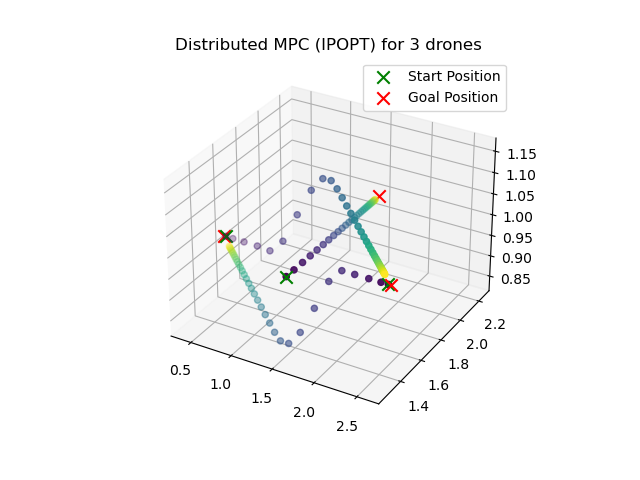

In [48]:
plt.figure()

%matplotlib ipympl
util.plot_solve(X_full, 0, xf, [6,6,6], False, n_d=3)
plt.title('Distributed MPC (IPOPT) for 3 drones');
plt.legend(plt.gca().get_children()[1:3], ["Start Position", "Goal Position"]);
# plt.savefig('results/Distributed MPC (IPOPT) for 3 drones.png')


## 5 drones:

In [ ]:
x0 = np.array([[-0.182, -0.545,  1.161,  0.   ,  0.   ,  0.   ,  1.335,  1.484,
         0.5  ,  0.   ,  0.   ,  0.   , -0.97 , -0.831,  2.295,  0.   ,
         0.   ,  0.   , -1.144, -1.193,  1.7  ,  0.   ,  0.   ,  0.   ,
         0.961,  1.085,  0.88 ,  0.   ,  0.   ,  0.   ]]).T
xf = np.array([[-1.751,  0.674, -1.193,  0.   ,  0.   ,  0.   ,  1.769,  0.102,
         2.998,  0.   ,  0.   ,  0.   , -1.452, -0.02 , -1.11 ,  0.   ,
         0.   ,  0.   ,  0.34 , -0.993, -0.832,  0.   ,  0.   ,  0.   ,
         1.094,  0.237,  0.137,  0.   ,  0.   ,  0.   ]]).T


n_agents = 5
n_states=6
n_inputs=3
x_dims = [n_states]*n_agents
u_dims = [n_inputs]*n_agents
radius=0.5
ids = [100 + i for i in range(n_agents)]

dt = 0.1

u_ref = np.tile(u_ref_base,n_agents)

ids = [100 + i for i in range(n_agents)]
N = 15

In [ ]:
t0 = perf_counter()
X_full,U_full, t= solve_rhc_distributed(x0,xf,u_ref,N,Q,R,Qf,n_agents,n_states,n_inputs,radius, ids)
tf = perf_counter()
print(f'\n Total run time for distributed RHC is {tf-t0}')

In [ ]:
plt.figure()

%matplotlib ipympl
util.plot_solve(X_full, 0, xf, [6,6,6,6,6], False, n_d=3)
plt.title('Distributed MPC (IPOPT) for 5 drones');
plt.legend(plt.gca().get_children()[1:3], ["Start Position", "Goal Position"]);
plt.savefig('results/Distributed MPC (IPOPT) for 5 drones.png')

## Distributed for 10 drones:

In [ ]:
x0 = np.array([[ 0.357,  0.799,  1.504,  0.   ,  0.   ,  0.   ,  2.172,  2.283,
         1.436,  0.   ,  0.   ,  0.   , -0.085,  0.577,  2.433,  0.   ,
         0.   ,  0.   ,  0.378,  0.254,  2.488,  0.   ,  0.   ,  0.   ,
         0.184,  0.344,  2.399,  0.   ,  0.   ,  0.   ,  2.094,  2.089,
         1.304,  0.   ,  0.   ,  0.   , -2.219, -3.09 ,  1.487,  0.   ,
         0.   ,  0.   , -0.6  , -0.406,  1.319,  0.   ,  0.   ,  0.   ,
        -2.059, -3.279,  1.48 ,  0.   ,  0.   ,  0.   , -0.222,  0.43 ,
         2.325,  0.   ,  0.   ,  0.   ]]).T
xf = np.array([[ 1.115,  1.749,  3.871,  0.   ,  0.   ,  0.   ,  0.653,  1.288,
         1.529,  0.   ,  0.   ,  0.   , -1.373, -0.243,  2.488,  0.   ,
         0.   ,  0.   , -1.314,  0.229,  1.771,  0.   ,  0.   ,  0.   ,
         1.735,  1.558,  2.081,  0.   ,  0.   ,  0.   ,  0.852, -1.583,
         2.264,  0.   ,  0.   ,  0.   ,  0.387, -1.5  ,  1.685,  0.   ,
         0.   ,  0.   , -1.26 , -0.697,  2.494,  0.   ,  0.   ,  0.   ,
        -0.213, -0.138,  1.545,  0.   ,  0.   ,  0.   , -0.582, -0.663,
         2.518,  0.   ,  0.   ,  0.   ]]).T


n_agents = 10
n_states=6
n_inputs=3
x_dims = [n_states]*n_agents
u_dims = [n_inputs]*n_agents
radius=0.1
ids = [100 + i for i in range(n_agents)]

dt = 0.01

u_ref = np.tile(u_ref_base,n_agents)

ids = [100 + i for i in range(n_agents)]
N = 5

In [ ]:
u_ref

In [ ]:
t0 = perf_counter()
X_full,U_full, t= solve_rhc_distributed(x0,xf,u_ref,N,Q,R,Qf,n_agents,n_states,n_inputs,radius, ids)
tf = perf_counter()
print(f'\n Total run time for distributed RHC is {tf-t0}')

In [ ]:
X_full.shape

In [ ]:
%matplotlib ipympl
plt.figure()

util.plot_solve(X_full, 1142, xf, [6,6,6,6,6,6,6,6,6,6], n_d=3)
plt.title('Distributed MPC (IPOPT) for 10 drones');
plt.legend(plt.gca().get_children()[1:3], ["Start Position", "Goal Position"]);
plt.savefig('results/Distributed MPC (IPOPT) for 10 drones.png')

In [ ]:
plt.figure()
plt.plot(util.compute_pairwise_distance(X_full, x_dims, 3))
plt.hlines(0.3, 0, x_trj.shape[0], 'r', ls='--', label="$d_{prox}$")
plt.title("Inter-Agent Distances")
plt.xlabel("Time Steps")
plt.ylabel("Distance")
plt.legend()
plt.grid()
plt.draw()